In [89]:
# Data
import dowhy.datasets
import numpy as np
import pandas as pd

# 1. Syntethic Data for linear problems:

# With this we generate a syntethic dataset, in order to see wheater our methods work well or not

# The real model is:
# y=b0+b1*v0+b2*w0+b3*w1+b4*w2+b5*w3+b6*w4+[b7@x1[True=1]+b8*x1[True=2]+b9*x1[True=3]+b10*x0 + the inetreaction of all the x's
# with v0] + u

# Basically, here we assume that we observe all factors that might be realated with the treatment and with the outcome
# and that they affect (specificaty problem) linearly the outcome

df = dowhy.datasets.linear_dataset(
    beta=3,  # This is the real coefficient of the treament in the lineal model, effect of the treamtment on the outcome
    # Number of variables that affect both the treatment (are in the error e) and the outcome (cov(v0,Wi) not 0).
    # I guess is the ATE
    num_common_causes=5,
    # This are basically ommited variables, hence if you do y=b0+b1*v0+b2*w0+b3*w1+b4*w2+b5*w3+b6*w4+u via OLS, you got  that
    # Now the b1 consistely estimate b1!!! (which is the beta).
    # All W's are independent from one another
    # Causality :w->v0,w->y.
    # I beleive this are exogenous variables, i.e., once inside the regression, they are not related anymore with the error term...
    num_discrete_common_causes=1,
    # This says one of the W's is discrete
    num_instruments=5,
    # Number of correct instrumental variables for the treatment: Cov(v0, Zi)!=0, Cov(e, zi)=0. Hence, in the regression
    # y=b0+b1*v0+e, this variables are related in covariance with v0, but are in no way related in covariance with e (where in the e we got the W's)
    # Causality :z->v0->Y0. Notice that in standard regression the problem always is: error->v0->Y0<-error, hence now we find some
    # Z that just affects v0 and is not realeted to error...
    # num_frontdoor_variables=1,
    # Basically, this are kind of like IV, but with the difference that now you got the FD0 as a mechanism though which
    # v0 causes Y0. This are endogenous withing the model itself!!!
    # Hence, now you estimate: v0->FD0->Y0.They have their own regression and stuff. Appers to be good for some autoselection problems, though perhaps less than IV. Check:The Book of Why
    num_treatments=1,
    # This is the number of  treatment variable we are intrested in estimate.
    num_samples=10000,
    # num_effect_modifiers=2,
    # This are effect modifiers. Esentially, this is the case when the effect of the treatment depend on specific caracteristics
    # of the individual. Say, if one is a Man or a Woman. This is why, to estimate the B1 correctly, you must include the X's and the
    # interaction of the X's with the treatment v0 (not with W's, since they are exogenous once inside the equation and not realted
    # witn X never)
    # num_discrete_effect_modifiers=1,
    # This will make the effect modifiers take on categorical values, like {0,1,2,3}, hence, in the regresion due to perfect
    # multicolinearity problems, just include indicators variables for 3 of the cases. Patsy or Fomulaic will do this automatically for you
    treatment_is_binary=True,
    # Traeat binarity
    outcome_is_binary=False,
    # Outcome binarity
)

data = df["df"]
y = 33*data.v0+abs(5*data.W0**2+6*np.log(abs(data.W1))-0.9*data.W3**5/(data.W2+5)
                   )**abs(data.W1)-(5*data.W4.astype(float)-data.W2**6+6*data.W1*data.W2)/5


def flatten_outliers(df, column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 3 * IQR
    upper_bound = Q3 + 3 * IQR
    df.loc[df[column] < lower_bound, column] = df[column].loc[(
        df[column] >= lower_bound) & (df[column] <= upper_bound)].iloc[0]
    df.loc[df[column] > upper_bound, column] = df[column].loc[(
        df[column] >= lower_bound) & (df[column] <= upper_bound)].iloc[-1]
    return df

# Example usage


y = flatten_outliers(pd.DataFrame(y), 0)

y.describe()
Z0 = data.Z0
Z1 = 33*data.Z1
new_data = data
new_data["y"] = y
new_data["Z0"] = Z0
new_data["Z1"] = Z1
df["df"] = new_data
data = df["df"]
# Note: The real param Now is beta=33!!!
data

,Z0,Z1,Z2,Z3,Z4,W0,W1,W2,W3,W4,v0,y
0,0.0,14.714355,1.0,0.819081,1.0,1.882505,0.660111,-1.683599,0.413450,0,True,44.922221
1,1.0,18.357965,1.0,0.680566,1.0,2.778156,0.470686,0.125703,-0.221903,0,True,38.192351
2,1.0,12.317443,1.0,0.514853,0.0,0.270594,0.663295,-0.850147,1.306190,1,True,34.788545
3,1.0,23.831608,1.0,0.036544,1.0,0.450510,-1.020931,0.037123,1.331489,1,True,32.429221
4,1.0,21.351945,0.0,0.554441,1.0,1.542301,1.207510,1.078226,1.103020,3,True,50.442541
...,...,...,...,...,...,...,...,...,...,...,...,...
9995,1.0,1.542645,0.0,0.638197,1.0,0.234209,0.043405,1.061554,0.084631,3,True,31.366060
9996,1.0,24.053385,0.0,0.322663,1.0,-0.029386,-0.924096,0.284661,-0.871820,2,True,31.728256
9997,1.0,10.965877,1.0,0.737602,1.0,1.755495,0.304029,0.368886,1.082253,2,True,32.748838
9998,1.0,20.015206,0.0,0.211153,0.0,0.632332,0.006785,-0.381942,2.191372,1,True,33.028683


In [144]:
# Compute the propensity score (logit...)
from causalml.propensity import ElasticNetPropensityModel
from formulaic import model_matrix
y, X = model_matrix("v0 ~ W0+W1+W2+W3+W4", data=data)
pm = ElasticNetPropensityModel(n_fold=5, random_state=42)
ps = pm.fit_predict(X, y)
ps

c:\Users\zeroi\miniconda3\envs\eco\lib\site-packages\sklearn\utils\validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\zeroi\miniconda3\envs\eco\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\zeroi\miniconda3\envs\eco\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\zeroi\miniconda3\envs\eco\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\zeroi\miniconda3\envs\eco\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did no

array([0.99883269, 0.999     , 0.999     , ..., 0.999     , 0.999     ,
       0.99860401])

         Current function value: 0.009250
         Iterations: 35


c:\Users\zeroi\miniconda3\envs\eco\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


<Axes: >

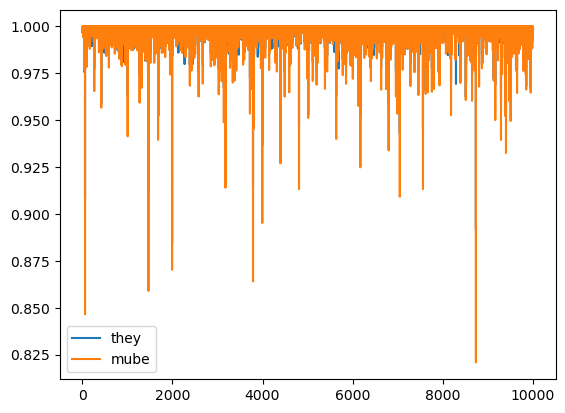

In [143]:
import statsmodels.api as sm
comparison_propensity = pd.DataFrame(
    {"they": ps, "mube": sm.Logit(y, X).fit(cov_type="HC3").predict()})
comparison_propensity.plot()

In [201]:
new_data = pd.concat([data, pd.DataFrame(ps)], axis=1)
new_data.columns.values[-1] = "pscore"
new_data

,Z0,Z1,Z2,Z3,Z4,W0,W1,W2,W3,W4,v0,y,pscore
0,0.0,14.714355,1.0,0.819081,1.0,1.882505,0.660111,-1.683599,0.413450,0,True,44.922221,0.998833
1,1.0,18.357965,1.0,0.680566,1.0,2.778156,0.470686,0.125703,-0.221903,0,True,38.192351,0.999000
2,1.0,12.317443,1.0,0.514853,0.0,0.270594,0.663295,-0.850147,1.306190,1,True,34.788545,0.999000
3,1.0,23.831608,1.0,0.036544,1.0,0.450510,-1.020931,0.037123,1.331489,1,True,32.429221,0.999000
4,1.0,21.351945,0.0,0.554441,1.0,1.542301,1.207510,1.078226,1.103020,3,True,50.442541,0.999000
...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,1.0,1.542645,0.0,0.638197,1.0,0.234209,0.043405,1.061554,0.084631,3,True,31.366060,0.999000
9996,1.0,24.053385,0.0,0.322663,1.0,-0.029386,-0.924096,0.284661,-0.871820,2,True,31.728256,0.998511
9997,1.0,10.965877,1.0,0.737602,1.0,1.755495,0.304029,0.368886,1.082253,2,True,32.748838,0.999000
9998,1.0,20.015206,0.0,0.211153,0.0,0.632332,0.006785,-0.381942,2.191372,1,True,33.028683,0.999000


In [232]:
from causalml.match import NearestNeighborMatch, create_table_one, MatchOptimizer
psm = NearestNeighborMatch(replace=True,
                           ratio=1,
                           random_state=42)
matched = psm.match(data=new_data,
                             treatment_col="v0",
                             score_cols=["W0", "W1", "W2", "W3", "pscore"],
                             )
create_table_one(data=matched,
                 treatment_col="v0",
                 features=["W0", "W1", "W2", "W3"])

,Control,Treatment,SMD
Variable,,,
n,92,92,
W0,0.62 (0.52),0.61 (0.53),-0.0237
W1,-0.21 (0.35),-0.19 (0.41),0.0461
W2,0.01 (0.60),0.01 (0.62),-0.0005
W3,0.78 (0.33),0.77 (0.40),-0.0433
